## Table of contents
* [Overview](#Overview)
* [1. Imports](#1.-Imports)
* [2. Read Pickle](#2.-Read-Pickle)
* [3. Check Data Imbalance](#3.-Check-Data-Imbalance)
* [4. Choose Model](#4.-Choose-Model)
* [5. Optimization](#5.-Optimization)

## Overview

1. Import library
2. Read pickle. (Pickle dataframe is already scaled with dummy variables)
3. Address data imbalance
4. Split test and train dataset.
5. Run four different models and select a model with the best value.
6. Optimize random forest by using bayesian optimization

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
import math
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from lightgbm import LGBMClassifier


## 2. Read Pickle

In [2]:
# Dataframe is already scaled with dummy variables
df = pd.read_pickle('df_preprocessed_1016.pkl')

In [3]:
df.head()

,Tenure Months_SS,Monthly Charges_SS,Total Charges_SS,Churn Score_SS,CLTV_SS,Churn Label,Gender_Female,Gender_Male,Senior Citizen_No,Senior Citizen_Yes,...,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless Billing_No,Paperless Billing_Yes,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,-1.236724,-0.362660,-0.958066,1.268402,-0.981675,Yes,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1
1,-1.236724,0.197365,-0.938874,0.385650,-1.436462,Yes,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
2,-0.992402,1.159546,-0.643789,1.268402,0.821409,Yes,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0
3,-0.177995,1.330711,0.338085,1.175481,0.509483,Yes,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0
4,0.677133,1.294151,1.216150,1.407784,0.794358,Yes,0,1,1,0,...,1,1,0,0,0,1,1,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 49 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Tenure Months_SS                          7043 non-null   float64
 1   Monthly Charges_SS                        7043 non-null   float64
 2   Total Charges_SS                          7043 non-null   float64
 3   Churn Score_SS                            7043 non-null   float64
 4   CLTV_SS                                   7043 non-null   float64
 5   Churn Label                               7043 non-null   object 
 6   Gender_Female                             7043 non-null   uint8  
 7   Gender_Male                               7043 non-null   uint8  
 8   Senior Citizen_No                         7043 non-null   uint8  
 9   Senior Citizen_Yes                        7043 non-null   uint8  
 10  Partner_No                          

In [5]:
# Put 1 and 0 for Dependent variable - 'Churn Label' to run logistics regression without an issue. 
df['Churn Label'].replace("Yes", 1, inplace=True)
df['Churn Label'].replace("No", 0, inplace=True)

## 3. Check Data Imbalance

In [6]:
X = df.loc[:, df.columns != 'Churn Label']
y = df.loc[:, df.columns == 'Churn Label']
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [7]:
# check the dimension of the splited dataset
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4930, 48)
(2113, 48)
(4930, 1)
(2113, 1)


Dependent variable is imbalanced, i am going to balance the varaible by using SMOTE.

In [8]:
# Over sampling using SMOTE (Synthetic Minority Oversampling Technique)
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
columns = X_train.columns

In [9]:
# SMOTE - Continue..
os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns = columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['Churn Label'])

# Check the numbers of data
print("length of oversampled data is ", len(os_data_X))
print("number of no churn in oversampled data ", len(os_data_y[os_data_y['Churn Label']==0]))
print("number of yes churn ", len(os_data_y[os_data_y['Churn Label']==1]))
print("proportion of no churn data in oversampled data is ", len(os_data_y[os_data_y['Churn Label']==0])/len(os_data_X))
print("proportion of yes churn data in oversampled data is ", len(os_data_y[os_data_y['Churn Label']==1])/len(os_data_X))

length of oversampled data is  7230
number of no churn in oversampled data  3615
number of yes churn  3615
proportion of no churn data in oversampled data is  0.5
proportion of yes churn data in oversampled data is  0.5


In [10]:
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y,test_size=0.3, random_state=0)

In [11]:
# check the dimension of the splited dataset
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


y_train['Churn Label'].value_counts()

(5061, 48)
(2169, 48)
(5061, 1)
(2169, 1)


0    2532
1    2529
Name: Churn Label, dtype: int64

## 4. Choose Model

### 4-1 Logistic Regression

#### Cross Validation

In [12]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# create model
model = LogisticRegression(solver='newton-cg')
model_res = model.fit(X_train, y_train.values.ravel())
y_pred = model_res.predict(X_test)

# evaluate model
scores = cross_val_score(model, y_test, y_pred, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

print(scores)

Accuracy: 0.943 (0.013)
[0.93548387 0.91705069 0.96774194 0.94930876 0.93548387 0.94009217
 0.95852535 0.94930876 0.93548387 0.94444444]


#### Confusion Matrix

In [13]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[1012   71]
 [  52 1034]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1083
           1       0.94      0.95      0.94      1086

    accuracy                           0.94      2169
   macro avg       0.94      0.94      0.94      2169
weighted avg       0.94      0.94      0.94      2169



#### Check Coefficient 

Coffcient tells how feature impacts on depdendent variable.

In [14]:
importance=model.coef_[0]
importance=np.sort(importance)

for index,val in enumerate(importance):
    print("Feature : {}  has score  : {} ".format(model.feature_names_in_[index],val))


Feature : Tenure Months_SS  has score  : -2.101456337280077 
Feature : Monthly Charges_SS  has score  : -1.889737377325105 
Feature : Total Charges_SS  has score  : -1.849929086205944 
Feature : Churn Score_SS  has score  : -1.7660984428794912 
Feature : CLTV_SS  has score  : -1.7640798390240253 
Feature : Gender_Female  has score  : -1.7448948353048308 
Feature : Gender_Male  has score  : -1.732887329380436 
Feature : Senior Citizen_No  has score  : -1.7325566909827657 
Feature : Senior Citizen_Yes  has score  : -1.7314540313680873 
Feature : Partner_No  has score  : -1.7034719489396253 
Feature : Partner_Yes  has score  : -1.6562312751959305 
Feature : Dependents_No  has score  : -1.6527941783451408 
Feature : Dependents_Yes  has score  : -1.6115763094056414 
Feature : Phone Service_No  has score  : -1.568077055886941 
Feature : Phone Service_Yes  has score  : -1.5619127664265509 
Feature : Multiple Lines_No  has score  : -1.4660334755775513 
Feature : Multiple Lines_No phone service

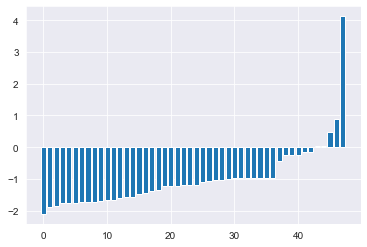

In [15]:
# plotting the features and their score in ascending order
sns.set_style("darkgrid")
plt.bar([i for i in range (len(importance))],importance)
plt.show()


#### Feature Importance

Feature Importance refers to techniques that calculate a score for all the input features for a given model — the scores simply represent the “importance” of each feature. **A higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain variable.**

In [16]:
importance=model.coef_[0]
feature_importance = pd.DataFrame(model.feature_names_in_, columns = ["feature"])
feature_importance['importance'] = pow(math.e, np.array(importance))

In [17]:
feature_importance.sort_values(by=['importance'],ascending = False)

,feature,importance
3,Churn Score_SS,61.922162
1,Monthly Charges_SS,2.470339
2,Total Charges_SS,1.616182
4,CLTV_SS,1.049515
14,Phone Service_Yes,1.037133
11,Dependents_No,0.872023
18,Internet Service_DSL,0.860210
39,Contract_Month-to-month,0.793260
13,Phone Service_No,0.776186
16,Multiple Lines_No phone service,0.776186


### 4-2 Random Forest

#### Cross Validation

In [18]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# create model
model = RandomForestClassifier()
model_res = model.fit(X_train, y_train.values.ravel())
y_pred = model_res.predict(X_test)

# evaluate model
scores = cross_val_score(model, y_test, y_pred, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

print(scores)

Accuracy: 0.951 (0.007)
[0.94930876 0.93548387 0.95391705 0.95852535 0.94470046 0.95391705
 0.96313364 0.94470046 0.95391705 0.94907407]


#### Confusion Matrix

In [19]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[1003   80]
 [  27 1059]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1083
           1       0.93      0.98      0.95      1086

    accuracy                           0.95      2169
   macro avg       0.95      0.95      0.95      2169
weighted avg       0.95      0.95      0.95      2169



#### Feature Importance

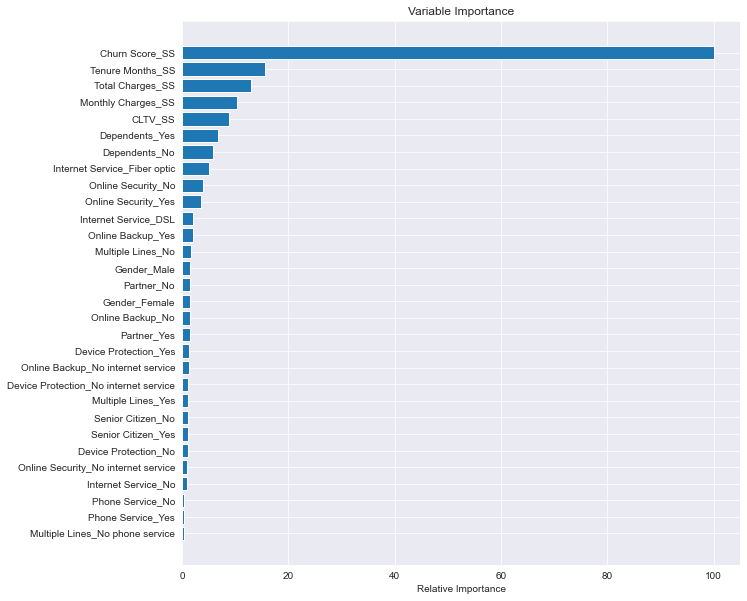

In [20]:
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
#print(pos.size)
#sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 4-3 Gradient Boosting

#### Cross Validation

In [21]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# create model
model = GradientBoostingClassifier()
model_res = model.fit(X_train, y_train.values.ravel())
y_pred = model_res.predict(X_test)


# evaluate model
scores = cross_val_score(model, y_test, y_pred, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

print(scores)

Accuracy: 0.943 (0.008)
[0.94470046 0.92165899 0.94009217 0.95391705 0.94470046 0.94470046
 0.94009217 0.94930876 0.94930876 0.93981481]


#### Confusion Matrix

In [22]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 998   85]
 [  39 1047]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1083
           1       0.92      0.96      0.94      1086

    accuracy                           0.94      2169
   macro avg       0.94      0.94      0.94      2169
weighted avg       0.94      0.94      0.94      2169



#### Feature Importance

30


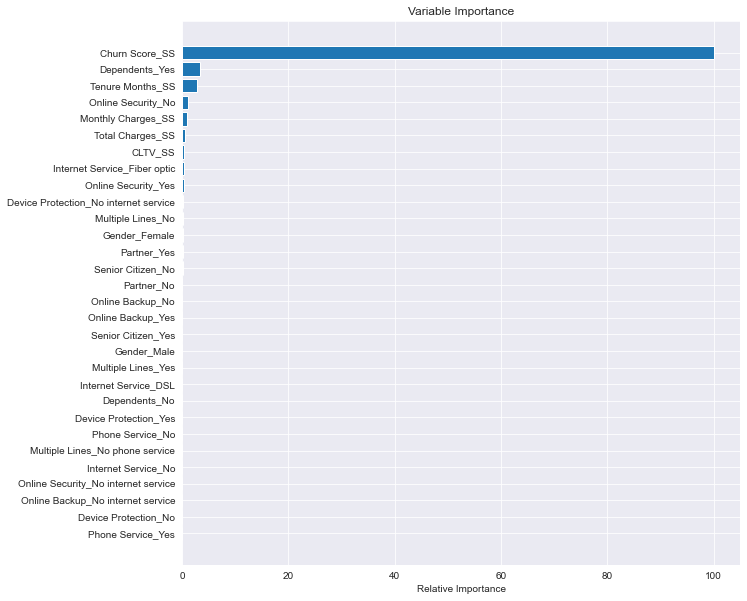

In [23]:
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

0.9915043982933974


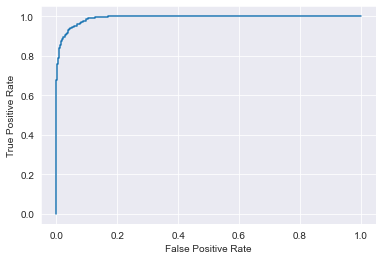

In [24]:
# ROC Curve
y_pred_prob = model_res.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)

print(roc_auc_score(y_test, y_pred_prob))


#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 4.4 LightGBM (Light Gradient Boosting Machine)

In [25]:
model = LGBMClassifier()
model.fit(X_train, y_train.values.ravel())
 
# Predicting the Target variable
pred = model.predict(X_test)
#print(pred)
accuracy = model.score(X_test, y_test)
print(accuracy)

0.9506685108344859


In [26]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# create model
model = LGBMClassifier()
model_res = model.fit(X_train, y_train.values.ravel())
y_pred = model_res.predict(X_test)


# evaluate model
scores = cross_val_score(model, y_test, y_pred, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

print(scores)

Accuracy: 0.951 (0.009)
[0.94470046 0.93548387 0.95852535 0.95391705 0.96313364 0.94009217
 0.95391705 0.94470046 0.95852535 0.9537037 ]


After executing cross validation and oversampling procedure, random forest gave me the best accuracy outcome (0.952) out of four models. Now, I am going to optimize logistic regression by using bayesian optimization.

## 5. Optimization

### Hyperparameter Tuning Random Forest with Bayesian Optimization

In [27]:
def objective(ne, ms, mf):
    regressor = RandomForestClassifier(n_estimators=int(ne), max_samples=ms, max_features=mf)

    regressor.fit(X_train, y_train.values.ravel())

    return regressor.score(X_test, y_test)

In [28]:
search_space = {
    "ne": (100, 300),
    "ms": (0.5,1.0),
    "mf": (0.5,1.0)
}

In [29]:
optimizer = BayesianOptimization(
                                f=objective,
                                pbounds=search_space,
                                random_state=100
                              )

In [30]:
optimizer.maximize(n_iter=100, init_points=10,acq='ei')


|   iter    |  target   |    mf     |    ms     |    ne     |
-------------------------------------------------------------
|  1        |  0.9493   |  0.7717   |  0.6392   |  184.9    |
|  2        |  0.9493   |  0.9224   |  0.5024   |  124.3    |
|  3        |  0.9484   |  0.8354   |  0.9129   |  127.3    |
|  4        |  0.9502   |  0.7875   |  0.9457   |  141.8    |
|  5        |  0.9484   |  0.5927   |  0.5542   |  143.9    |
|  6        |  0.9493   |  0.9893   |  0.9058   |  134.4    |
|  7        |  0.9497   |  0.9081   |  0.637    |  186.3    |
|  8        |  0.9484   |  0.97     |  0.9088   |  167.2    |
|  9        |  0.9488   |  0.5877   |  0.6864   |  101.1    |
|  10       |  0.9484   |  0.6262   |  0.8978   |  103.1    |
|  11       |  0.947    |  0.7517   |  0.947    |  141.6    |
|  12       |  0.9488   |  0.7672   |  0.6903   |  292.8    |
|  13       |  0.9479   |  0.8011   |  0.5359   |  155.0    |
|  14       |  0.947    |  0.5932   |  0.6699   |  180.7    |
|  15   

|  80       |  0.9497   |  0.5639   |  0.827    |  124.4    |
|  81       |  0.9488   |  0.9651   |  0.8609   |  292.9    |
|  82       |  0.9488   |  0.856    |  0.6268   |  210.4    |
|  83       |  0.9465   |  0.8554   |  0.5129   |  261.2    |
|  84       |  0.9479   |  0.8895   |  0.6161   |  156.0    |
|  85       |  0.9497   |  0.589    |  0.7865   |  229.5    |
|  86       |  0.9493   |  0.8483   |  0.8768   |  211.7    |
|  87       |  0.9484   |  0.7081   |  0.5835   |  195.0    |
|  88       |  0.9484   |  0.7075   |  0.5381   |  247.7    |
|  89       |  0.9488   |  0.9841   |  0.9475   |  238.4    |
|  90       |  0.9479   |  0.7647   |  0.5811   |  242.8    |
|  91       |  0.947    |  0.7288   |  0.7257   |  103.7    |
|  92       |  0.9502   |  0.532    |  0.618    |  285.6    |
|  93       |  0.9465   |  0.8818   |  0.7931   |  125.2    |
|  94       |  0.9502   |  0.5785   |  0.5245   |  279.8    |
|  95       |  0.9497   |  0.5456   |  0.6724   |  237.4    |
|  96   

In [31]:
optimizer.max

{'target': 0.9520516366989396,
 'params': {'mf': 0.5080833945225312,
  'ms': 0.9788650855858045,
  'ne': 228.29994742665698}}

Grid Search took so much time, so I chose to run with the bayesian optimization.

In [139]:
# create model
model = RandomForestClassifier(max_features=0.55, max_samples=0.65,n_estimators=123)
model_res = model.fit(X_train, y_train.values.ravel())
y_pred = model_res.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.950


In [148]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# create model
model = RandomForestClassifier(max_features=0.5489035815424221, max_samples=0.6450858683687302,n_estimators=122)
model_res = model.fit(X_train, y_train.values.ravel())
y_pred = model_res.predict(X_test)

# evaluate model
scores = cross_val_score(model, y_test, y_pred, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

print(scores)

Accuracy: 0.950 (0.009)
[0.94470046 0.93087558 0.95852535 0.95391705 0.95391705 0.94930876
 0.95391705 0.94930876 0.96313364 0.93981481]
